### **Text Mining Group Project 23-24**

#### **Group 3**

**Elements**:
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Diogo Almeida | 20230737 | 20230737@novaims.unl.pt
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt

**Index**
* [1. Library imports](#library-imports)
* [2. Constants](#constants)
* [3. Data Imports](#data-imports)
* [4. Data Exploration](#data-exploration)
    * [4.1. High-level statistics](#high-level-stats)

#### **Library Imports**<a id='library-imports'></a>

In [226]:
import os
import time
import re
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

from wordcloud import WordCloud 

import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # lexicon-based

import spacy
from simplemma import lemmatize, text_lemmatizer, simple_tokenizer  # https://github.com/adbar/simplemma

from bs4 import BeautifulSoup

import fasttext
from deep_translator import GoogleTranslator  # https://github.com/nidhaloff/deep-translator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from transformers import pipeline

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchtext.vocab as vocab

#### **Constants**<a id='constants'></a>

In [169]:
SEED = 42

RAW_DATA_DIR = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(RAW_DATA_DIR, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(RAW_DATA_DIR, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'test_reviews.xlsx')

TRAIN_PREPROCESSED = os.path.join('')
TEST_PREPROCESSED = os.path.join('')

#### **Data Imports**<a id='data-imports'></a>

In [170]:
class Metadata:
    
    """
    Easy access to metadata for the Airbnb dataset.
    """
    
    descriptions = {
        'index': 'index column to identify each property',
        'description': 'property description',
        'host_about': 'host information',
        'unlisted': 'target column: whether the property is unlisted (1) or not (0)',
        'comments': 'guest comments on the property. A property can have multiple or no comments',
    }
    
    @classmethod
    def describe(cls, column):
        return cls.descriptions[column]


# example
print(Metadata.describe('index'))

index column to identify each property


In [171]:
train_info_raw = pd.read_excel(TRAIN_INFO_PATH)
train_reviews_raw = pd.read_excel(TRAIN_REVIEWS_PATH)

print(f'Train info shape: {train_info_raw.shape}')
display(train_info_raw.head())
print()
print(f'Train reviews shape: {train_reviews_raw.shape}')
display(train_reviews_raw.head())

# we might also want to check the test data to ensure compatibility
test_info_raw = pd.read_excel(TEST_INFO_PATH)
test_reviews_raw = pd.read_excel(TEST_REVIEWS_PATH)

print(f'Test info shape: {test_info_raw.shape}')
display(test_info_raw.head())
print()
print(f'Test reviews shape: {test_reviews_raw.shape}')
display(test_reviews_raw.head())

assert test_info_raw.columns.tolist() == train_info_raw.columns.tolist()[:-1], 'Test and train info columns do not match'
assert test_reviews_raw.columns.tolist() == train_reviews_raw.columns.tolist(), 'Test and train reviews columns do not match'

# time to load: ~30s

Train info shape: (6248, 4)


,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0



Train reviews shape: (361281, 2)


,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


Test info shape: (695, 3)


,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...



Test reviews shape: (41866, 2)


,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


In [172]:
# during exploration we will transform the data
# we want to make them in a copy in order to not
# alter the original data
train_info = train_info_raw.copy()
train_reviews = train_reviews_raw.copy()
test_info = test_info_raw.copy()
test_reviews = test_reviews_raw.copy()

#### **Data Exploration**

- **High-level Statistics**

In [173]:
# missing values

# there seems to be blank spaces not being identified as nulls
# r'^\s*$' matches strings that are empty or contain only whitespace
# ^ asserts the start of the string
# \s* matches zero or more whitespace characters (spaces, tabs, newlines, etc.)
# $ asserts the end of the string

def replace_pseudo_nans(df):
    new_df = df.replace(r'^\s*$', np.nan, regex=True)
    new_df = new_df.replace('Nan', np.nan)
    return new_df

In [7]:
train_info = replace_pseudo_nans(train_info)
train_reviews = replace_pseudo_nans(train_reviews)

print('Train info missing values:')
print(train_info.isna().sum())

print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())

# to the same to the test set
test_info = test_info.replace(r'^\s*$', np.nan, regex=True)
test_reviews = test_reviews.replace(r'^\s*$', np.nan, regex=True)

print('\nTest info missing values:')
print(test_info.isna().sum())

print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

Train info missing values:
index           0
description     0
host_about     24
unlisted        0
dtype: int64

Train reviews missing values:
index       0
comments    2
dtype: int64

Test info missing values:
index          0
description    0
host_about     2
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64


In [16]:
# is index unique in train_info?
assert train_info['index'].nunique() == train_info.shape[0], 'Index is not unique'
print(f'Total no. of properties in train dataset: {train_info.shape[0]}')

Total no. of properties in train dataset: 6248


In [17]:
# are there duplicates?
print(f'Duplicate rows in train_info: {train_info.duplicated().sum()}')
print(f'Duplicate rows in train_reviews: {train_reviews.duplicated().sum()}')

print(f'\nDuplicate rows in test_info: {test_info.duplicated().sum()}')
print(f'Duplicate rows in test_reviews: {test_reviews.duplicated().sum()}')

# ... duplicate reviews:
print('\nSample of duplicates:')
display(test_reviews[test_reviews.duplicated(keep=False)].head(10))

# removing duplicates (only the reviews dfs have them)
train_reviews = train_reviews.drop_duplicates()
test_reviews = test_reviews.drop_duplicates()

Duplicate rows in train_info: 0
Duplicate rows in train_reviews: 142

Duplicate rows in test_info: 0
Duplicate rows in test_reviews: 15

Sample of duplicates:


,index,comments
1622,42,Great place
1645,42,Great place
8862,155,Good
8884,155,Good
11302,178,Great place!
11416,178,Great location!
11445,178,Great location!
11454,178,Great place!
11631,179,.
11829,179,.


In [10]:
# are there properties with reviews but without description?
assert set(train_info['index']).issuperset(set(train_reviews['index']))
assert set(test_info['index']).issuperset(set(test_reviews['index']))

# ... all properties in the reviews dfs exist in the info dfs

Unlisted: 1708 (27.34%)
Listed: 4540 (72.66%)


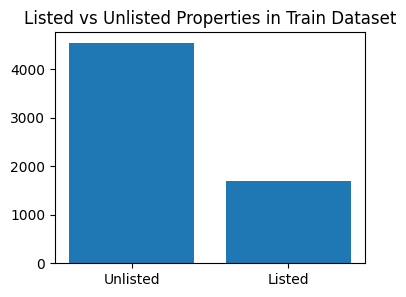

In [11]:
# listed vs unlisted
unlisted = train_info['unlisted'].value_counts()
print(f'Unlisted: {unlisted[1]} ({unlisted[1] / train_info.shape[0] * 100:.2f}%)')
print(f'Listed: {unlisted[0]} ({unlisted[0] / train_info.shape[0] * 100:.2f}%)')

plt.figure(figsize=(4,3))
plt.bar(['Unlisted', 'Listed'], unlisted)
plt.title('Listed vs Unlisted Properties in Train Dataset')
plt.show()

# ... some data imbalance, might need to address this later

In [12]:
# property reviews
reviews_per_property = train_reviews['index'].value_counts()

total_properties = train_info.shape[0]
properties_with_reviews = reviews_per_property.shape[0]
properties_without_reviews = total_properties - properties_with_reviews

print(f'Properties with reviews: {properties_with_reviews} ({properties_with_reviews / total_properties * 100:.2f}%)')
print(f'Properties without reviews: {properties_without_reviews} ({properties_without_reviews / total_properties * 100:.2f}%)')

Properties with reviews: 4245 (67.94%)
Properties without reviews: 2003 (32.06%)


In [13]:
# stats on reviews per property
avg_reviews_per_property = reviews_per_property.mean()
print(f'Average reviews per property: {avg_reviews_per_property:.2f}')
print(f'Median reviews per property: {reviews_per_property.median():.0f}')
print(f'Mode of reviews per property: {reviews_per_property.mode()[0]}')
print(f'Standard deviation of reviews per property: {reviews_per_property.std():.2f}')

Average reviews per property: 85.07
Median reviews per property: 48
Mode of reviews per property: 1
Standard deviation of reviews per property: 96.44


In [22]:
# are there properties with reviews but without host description?
missing_host_about_index = train_info[train_info['host_about'].isnull()]['index'].tolist()
train_reviews.loc[train_reviews['index'].isin(missing_host_about_index) & train_reviews['comments'].notnull(), :].shape

# ... yes, i.e. we can't drop the properties with no host about

(1021, 2)

- **Data Cleaning ahead of text field analysis**

In [7]:
# storing a copy of the data before cleaning for easier comparison
# between pre and post cleaning

# recall that only transformations done until now are:
# ... replacing pseudo nans with nans
# ... dropping duplicates from reviews

train_info_pre_clean = train_info.copy()
train_reviews_pre_clean = train_reviews.copy()

In [276]:
# cleaning functions
# NOTE some of this functions will be used for data pre processing!

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text


def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns (often used to indicate line breaks)
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text


def remove_or_replace_mentions(text):
    # '@' seems to be either used as a simplification of the word 'at'
    # or a mention. Therefore, if '@' is not attached to any other characters
    # then we will replace it with 'at', else will remove it as well as the
    # characters glued to it.
    if '@' in text:
        text = re.sub(r' @ ', 'at', text)
        text = re.sub(r'@(\w+)', '', text)
    return text


def remove_urls(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    return text


def remove_or_replace_hashtags(text):
    # not sure if they are really used as hashtags
    # but rather to mean 'number'/'best', e.g. # 1 spot in town!
    if '#1' or '# 1':
        text = re.sub(r'#\s?\b1\b', 'best', text)
    text = re.sub(r'#(\w+)', '', text)
    return text


def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text


def remove_double_withspaces(text):
    # the previous transformations might end up
    # creating duplicate whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text


def remove_functional_punctuation(text):
    # text = re.sub(r'[.,;:()!?\[\]{}]-', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('—', '')
    return text


def lower_case(text):
    return text.lower()


def strip(text):
    return text.strip()

In [277]:
# function chainer
# select which cleaning functions to use

def clean_text(text):
    # skip nans
    if pd.isna(text):
        return text
        
    text = remove_html_tags(text)    
    text = remove_emojis_and_special_characters(text)
    text = remove_control_characters(text)
    text = remove_functional_punctuation(text)
    text = remove_or_replace_mentions(text)
    text = remove_urls(text)
    text = remove_or_replace_hashtags(text)
    text = remove_numbers(text)
    text = remove_double_withspaces(text)
    text = lower_case(text)
    text = strip(text)
    
    return text

In [278]:
# testing the cleaning functions
print(clean_text('.'))
print(clean_text('-'))
print(clean_text('—-')) # fix
print(clean_text('Отличное расположение. Есть всё необходимое. Чисто, уютно. Есть утюг и фен, кофе чай'))
print(clean_text('一个完美的房子体验，非常干净和安静，房东非常热情，离老城区景点非常近，不能错过的房源 '))
print(clean_text('👍 top'))
print(clean_text('   great!!!   '))
print(clean_text('진짜 깔끔하고 있을거 다 구비되어 있습니다. 화장실 깔끔하게 온수도 잘 나오고 물빠짐도 좋아요..'))




отличное расположение есть всё необходимое чисто уютно есть утюг и фен кофе чай
一个完美的房子体验，非常干净和安静，房东非常热情，离老城区景点非常近，不能错过的房源
top
great
진짜 깔끔하고 있을거 다 구비되어 있습니다 화장실 깔끔하게 온수도 잘 나오고 물빠짐도 좋아요


In [225]:
remove_functional_punctuation('!!!')

'!!!'

In [10]:
# cleaning

train_info['clean_description'] = train_info['description'].apply(clean_text)
train_info['clean_host_about'] = train_info['host_about'].apply(clean_text)
train_reviews['clean_comments'] = train_reviews['comments'].apply(clean_text)

# takes around ~90s

- **Language Detection**

In [9]:
# using the fasttext library, developed by Facebook, to help detect language
# of text fields it is much faster than other libraries like langdetect

# how to:
# 1. go to: https://fasttext.cc/docs/en/language-identification.html
# 2. download lid.176.ftz and place it in the language-detection folder (if you have no such folder, create it beforehand)
# example: https://huggingface.co/facebook/fasttext-language-identification

class LanguageDetector:
    def __init__(self):
        self.model = self.load_model()
    
    def load_model(self):
        model = fasttext.load_model(os.path.join('language-detection', 'lid.176.ftz'))
        return model
    
    def detect_language(self, text):
        if pd.isna(text):
            return text
        return self.model.predict(text)[0][0].split('__')[-1]

In [ ]:
language_detector = LanguageDetector()
train_info['clean_description_lang'] = train_info['clean_description'].apply(lambda text: language_detector.detect_language(text))
train_info['clean_host_about_lang'] = train_info['clean_host_about'].apply(lambda text: language_detector.detect_language(text))
train_reviews['clean_comments_lang'] = train_reviews['clean_comments'].apply(lambda text: language_detector.detect_language(text))

description_languages = train_info['clean_description_lang'].value_counts()
host_about_languages = train_info['clean_host_about_lang'].value_counts()
comments_languages = train_reviews['clean_comments_lang'].value_counts()

print(f"No. of unique languages in clean_description_lang: {len(description_languages)}")
print(f"No. of unique languages in clean_host_about_lang: {len(host_about_languages)}")
print(f"No. of unique languages in clean_comments_lang: {len(comments_languages)}")

# ... note that description and host about can be in different languages!

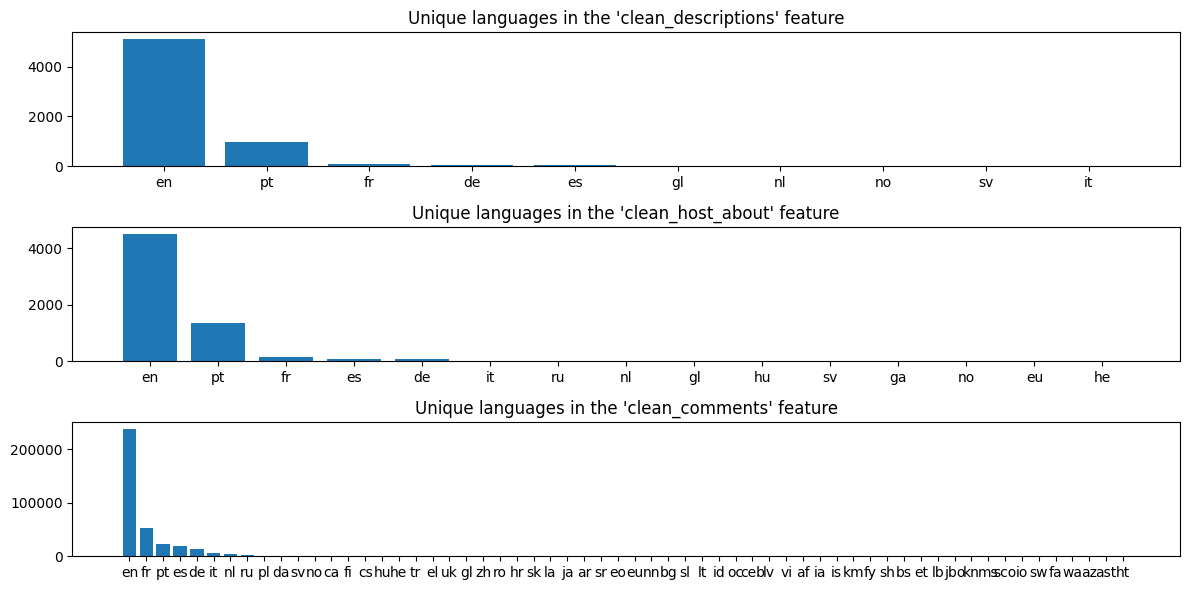

In [30]:
# plot most common languages

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

ax1.bar(description_languages.index, description_languages)
ax1.set_title("Unique languages in the 'clean_descriptions' feature")

ax2.bar(host_about_languages.index, host_about_languages)
ax2.set_title("Unique languages in the 'clean_host_about' feature")

ax3.bar(comments_languages.index, comments_languages)
ax3.set_title("Unique languages in the 'clean_comments' feature")

plt.tight_layout()
plt.show()

In [52]:
# the majority of text data is written in english or one of the romance languages

romance_languages = [
    'pt', 
    'fr',
    'es',
    'it',
    'ro'  # fyi, romanian
]

print('Proportion of observations in english or romance languages:')
print(f"\tdescriptions: {sum([v for k,v in description_languages.items() if k in ['en'] + romance_languages]) / sum(description_languages):.2f}")
print(f"\thost_about: {sum([v for k,v in host_about_languages.items() if k in ['en'] + romance_languages]) / sum(host_about_languages):.2f}")
print(f"\tcomments: {sum([v for k,v in comments_languages.items() if k in ['en'] + romance_languages]) / sum(comments_languages):.2f}")

Proportion of observations in english or romance languages:
	description: 0.99
	host_about: 0.98
	comments: 0.94


In [33]:
# all unique languages

uq_languages = set(
    list(description_languages.index) +
    list(host_about_languages.index) +
    list(comments_languages.index)
)

print(f"Total unique languages: {len(uq_languages)}")

Total unique languages: 61


In [ ]:
# ... and on the test set?

- **Word Count and Cloud**

In [26]:
def word_counter(text):
    if pd.isna(text):
        return 0
    return len(text.split(' '))

word_count_description = train_info['clean_description'].map(word_counter)
word_count_host_about = train_info['clean_host_about'].map(word_counter)
word_count_comments = train_reviews['clean_comments'].map(word_counter)

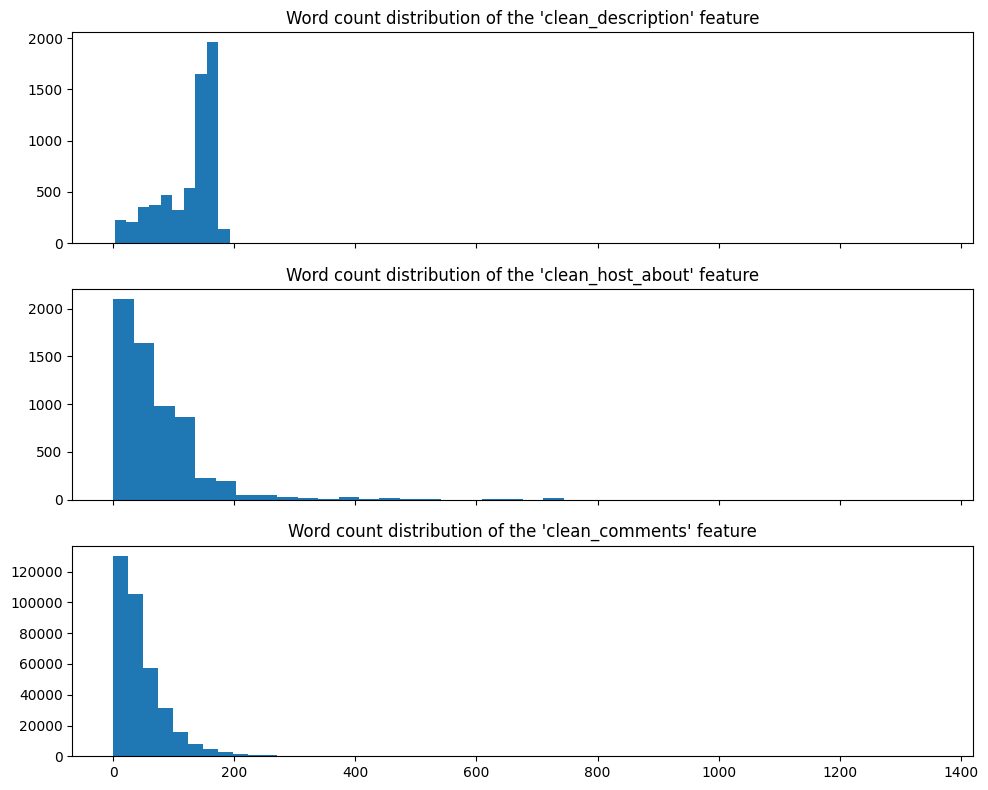

In [36]:
# plot most common languages

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax1.hist(word_count_description, bins=10)
ax1.set_title("Word count distribution of the 'clean_description' feature")

ax2.hist(word_count_host_about, bins=40)
ax2.set_title("Word count distribution of the 'clean_host_about' feature")

ax3.hist(word_count_comments, bins=40)
ax3.set_title("Word count distribution of the 'clean_comments' feature")

plt.tight_layout()
plt.show()

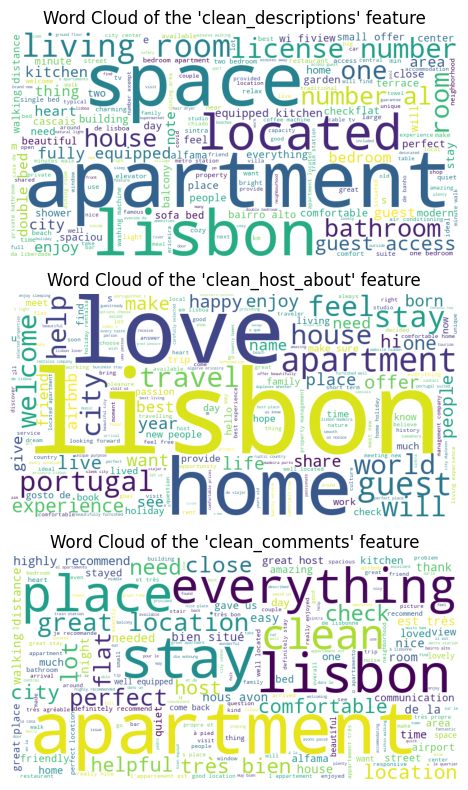

In [46]:
# word cloud

joint_description = ' '.join([text for text in train_info['clean_description'] if not pd.isna(text)])
joint_host_about = ' '.join([text for text in train_info['clean_host_about'] if not pd.isna(text)])
joint_comments = ' '.join([text for text in train_reviews['clean_comments'] if not pd.isna(text)])

wordcloud_description = WordCloud(width=800, height=400, background_color="white").generate(joint_description)
wordcloud_host_about = WordCloud(width=800, height=400, background_color="white").generate(joint_host_about)
wordcloud_comments = WordCloud(width=800, height=400, background_color="white").generate(joint_comments)

# plotting clouds
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))

ax1.imshow(wordcloud_description)
ax1.set_title("Word Cloud of the 'clean_descriptions' feature")
ax1.axis('off')

ax2.imshow(wordcloud_host_about)
ax2.set_title("Word Cloud of the 'clean_host_about' feature")
ax2.axis('off')

ax3.imshow(wordcloud_comments)
ax3.set_title("Word Cloud of the 'clean_comments' feature")
ax3.axis('off')

plt.tight_layout()
plt.show()

- **N-Grams**

In [ ]:
# ... n-grams?

- **Text Translation to English**

In [ ]:
# what to do to languages that are not possible to translate?

pretrained_translators_names = {
    'af': None,  # afrikaans
    'ar': None,  # arabic
    'ast': None, # asturian (no asturian, using romance)
    'az': None, # azerbaijani
    'bg': None, # bulgarian
    'bs': None, # bosnian
    'ca': None, # catalan
    'ceb': None, # cebuano
    'cs': None, # czech
    'da': 'Helsinki-NLP/opus-mt-da-en', # danish
    'de': 'Helsinki-NLP/opus-mt-en-de', # german
    'el': None, # greek
    'en': None, # english (no translation needed)
    'eo': None, # esperanto
    'es': 'Helsinki-NLP/opus-mt-ROMANCE-en', # spanish
    'et': None, # estonian
    'eu': None, # basque
    'fa': None, # persian
    'fi': None, # finnish
    'fr': 'Helsinki-NLP/opus-mt-ROMANCE-en', # french
    'fy': None, # frisian
    'ga': None, # irish
    'gl': None, # galecian
    'he': None, # hebrew
    'hr': None, # croatian
    'ht': None, # haitian creole
    'hu': None, # hungarian
    'ia': None, # interlingua
    'id': None, # indonesian
    'io': None, # ido
    'is': None, # icelandic
    'it': 'Helsinki-NLP/opus-mt-ROMANCE-en', # italian
    'ja': None, # japanese
    'jbo': None, # lojban
    'km': None, # khmer
    'kn': None, # kannada
    'la': None, # latin
    'lb': None, # luxembourghish
    'lt': None, # lithuanian
    'lv': None, # latvian
    'ms': None, # malay
    'nl': 'Helsinki-NLP/opus-mt-nl-en', # dutch
    'nn': None, # norwegian (nynorsk)
    'no': None, # norwegian
    'oc': None, # occitan
    'pl': 'Helsinki-NLP/opus-mt-pl-en', # polish
    'pt': 'Helsinki-NLP/opus-mt-ROMANCE-en', # portuguese
    'ro': 'Helsinki-NLP/opus-mt-ROMANCE-en', # romanian
    'ru': 'Helsinki-NLP/opus-mt-ru-en', # russsian
    'sco': None, # scots
    'sh': None, # serbo-croatian
    'sk': None, # slovak
    'sl': None, # slovenian
    'sr': None, # serbian
    'sv': None, # swedish
    'sw': None, # swahili
    'tr': None, # turkish
    'uk': None, # ukranian
    'vi': None, # vietnamese
    'wa': None, # walloon
    'zh': None # chinese
}

able_to_translate = [k for k,v in pretrained_translators_names.items() if v is not None]
print('Proportion of observations in english or languages that we can translate into english:')
print(f"\tdescriptions: {sum([v for k,v in description_languages.items() if k in ['en'] + able_to_translate]) / sum(description_languages):.4f}")
print(f"\thost_about: {sum([v for k,v in host_about_languages.items() if k in ['en'] + able_to_translate]) / sum(host_about_languages):.4f}")
print(f"\tcomments: {sum([v for k,v in comments_languages.items() if k in ['en'] + able_to_translate]) / sum(comments_languages):.4f}")

# ... it seems that we are able to translate >99% of all the texts
# what if, if we use translation, we can just hard predict 'listed'
# (the majority class) for all instances where we can't translate?

In [25]:
# possibility: https://huggingface.co/docs/transformers/model_doc/marian
# multilingual translator: https://huggingface.co/datasets/Helsinki-NLP/opus-100

# TODO checkout this lib: https://github.com/UKPLab/EasyNMT

# can we use a sample to perform sentiment analysis?
# but what about other the other languages when we want to do predictions?

class MultiLingualTranslator:
    def __init__(self, pretrained_translators_names):
        self.pretrained_translators_names = pretrained_translators_names
        self.loaded_pipelines = {}

    def load_pipeline(self, model_name):
        if model_name not in self.loaded_pipelines:
            pipe = pipeline("translation", model=model_name)
            self.loaded_pipelines[model_name] = pipe
        else:
            pipe = self.loaded_pipelines[model_name]
            
        return pipe

    def _get_model_name(self, lang):
        return self.pretrained_translators_names.get(lang)

    def translate_to_english(self, text, lang) -> str:
        if lang == 'en':
            return text
        elif lang not in [k for k,v in pretrained_translators.items() if v is not None]:
            return np.nan

        model_name = self._get_model_name(lang)
        pipe = self.load_pipeline(model_name)
        # output of pipe is a list of dicts, e.g. [{'translation_text': '...'}]
        translation = pipe(text)[0]["translation_text"]
        return translation

# it seems that translation affects some cleaning tasks
# e.g. adds puncation
# capitalizes some letters
# ... need to re-clean

In [ ]:
translator = MultiLingualTranslator(pretrained_translators_names)

def translate(text, lang, clean=True):
    # text might be null
    if pd.isna(text):
        return text

    translation = translator.translate_to_english(text, lang)

    # the class returns np.nan for languages without translator model
    if pd.isna(translation):
        return translation

    if clean:
        # translation seems able to add punctuation
        # and capitalize some letters
        translation = remove_functional_punctuation(translation)
        translation = lower_case(translation)
    
    return translation

# doing it this way just because of the tqdm
def apply_clean_translation_to_df(text_column, lang_column):
    new_col = []
    for text, lang in tqdm(zip(text_column, lang_column), total=len(text_column), desc="Translating text"):
        translation = translate(text, lang)
        new_col.append(translation)


# ... takes an unfeasible amount of time
# train_info['translated_clean_description'] = apply_clean_translation_to_df(train_info['clean_description'], train_info['clean_description_lang'])
# train_info['translated_clean_host_about'] = apply_clean_translation_to_df(train_info['clean_host_abou'], train_info['clean_host_abou_lang'])
# train_info['translated_clean_comments'] = apply_clean_translation_to_df(train_reviews['clean_comments'], train_reviews['clean_comments_lang'])

In [51]:
# TODO maybe use this for translating other languages?
# if yes add it to class

translated = GoogleTranslator(source='pt', target='en').translate("bom dia chamo me frederico")
translated

# ... also need to re-clean text
# ... also takes a lot of time

- **Sentiment Analysis of the 'comments' feature**

In [ ]:
# there are basically 3 types of sentiment analysis:
# 1. lexicon-based
# 2. machine learning-based
# 3. pre-trained transformer-based deep learning

# ... maybe we only need the simplest method?

# since translation might not be viable we can use the english reviews as a sample
# and do sentiment analysis on those?

# example of lexicon-based sentiment analysis: https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

In [106]:
en_comments = train_reviews.loc[train_reviews['clean_comments_lang'] == 'en', ['index', 'clean_comments']]  # later will merge with the unlisted feature

print('No. of english ocurrences:')
print(f'\t comments: {len(en_comments)}/{len(train_reviews)}')

# ... shouldn't description and host_about have the exact same numbers?

No. of english ocurrences:
	 comments: 238351 / 361281


In [107]:
# some pre processing functions, besides simple text cleaning, may help
# the accuracy of the sentiment analysis

# instantiating outside of function to speed up process
en_stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_en_text(text):

    # tokenizing the text
    tokens = word_tokenize(text)

    # removing stop words
    filtered_tokens = [token for token in tokens if token not in en_stop_words]

    # lemmatizing the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # joining the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text


en_comments['processed_comments'] = en_comments['clean_comments'].apply(preprocess_en_text)

# ... takes around 2 min

In [108]:
# sentiment analyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # compound ranges from -1 to 1
    sentiment = 1 if scores['compound'] > .5 else 0
    return sentiment


en_comments['processed_comments_sentiment'] = en_comments['processed_comments'].apply(get_sentiment)
print(en_comments['processed_comments_sentiment'].value_counts())

# ... takes around 2 min

processed_comments_sentiment
1    221268
0     17083
Name: count, dtype: int64


In [109]:
# re-structuring the df

# there can be multiple comments for a house
# se we first should take the mode scores
# and then turn it to boolean like the rest
# (hence we did not want to convert to bool)

def mode(series):
    mode = pd.Series.mode(series)
    if len(mode) > 1:
        mode = 0
    return mode

en_comments = (
    en_comments
    .groupby('index')
    .agg({'processed_comments_sentiment': lambda x: mode(x)})
    .reset_index()
)

# merging with info df to get the unlisted feature
en_comments = en_comments.merge(train_info[['index', 'unlisted']],
                                on='index', how='left')

In [110]:
# chi-square test for independence
# H0: There is no significant relationship between Variable A and Variable B.
# vs.
# H1: There is a significant relationship between Variable A and Variable B
# therefore, rejecting the null suggests that there is evidence of an
# association between the variables.

contingency_table = pd.crosstab(en_comments['processed_comments_sentiment'],
                                en_comments['unlisted'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)
# print("Degrees of freedom:", dof)
# print("Expected frequencies:")
# print(expected)
print(f"Conclusion: {'Reject' if p < 0.05 else 'Fail to reject'} the null.")

Chi-square statistic: 9.07502660414605
p-value: 0.002591238062242306

Conclusion: Reject the null.


In [ ]:
# limitations
# ... english observations might not be representative of the whole data
# ... data cleaning / processing might cause bias
# ... reviews might put out mixed signals, e.g. bad review about property, positive reiew
#     about trip, 'apartment was awful but the city was mesmerizing', model might predict
#     positive sentiment.
# ... lack of accuracy of the sentiment analyser used
# ... lack of power of the chi-square test

In [ ]:
# ... do this for the other 2 fields?

#### **Data Merge (for both original train and test datasets)**

In [348]:
# Although during data exploration we have employed several
# pre-processing and feature engineering techniques the data
# split will be of the raw data since the techniques employed
# might be undone / new techniques might be employed later on.

# can we treat each property-guest review as independent?
# ... IMO yes, since we reviews are not dated and therefore
# we cannot establish a temporal relationship between them
# e.g. if last 5 reviews are bad then house is more likely
# to be unlisted.

# merging, for train and test datasets, info and reviews
# no pre processing whatsoever!

# merging both train datasets
train_merged = train_info_raw.merge(train_reviews_raw,
                                    on='index',
                                    how='outer')

# merging both test sets
test_merged = test_info_raw.merge(test_reviews_raw,
                                  on='index',
                                  how='outer')

# making sure all is good for both merged datasets
assert set(train_merged['index'].unique().tolist()) == set(train_info_raw['index'].unique().tolist() + train_reviews_raw['index'].unique().tolist()), 'Missing indexes in train_merged'
assert set(test_merged['index'].unique().tolist()) == set(test_info_raw['index'].unique().tolist() + test_reviews_raw['index'].unique().tolist()), 'Missing indexes in test_merged'

print(f'Train merged shape: {train_merged.shape}')
print(f'Test merged shape: {test_merged.shape}')

Train merged shape: (363284, 5)
Test merged shape: (42086, 4)


#### **Data Preprocessing**

In [60]:
# data pre processing will be done to the raw, un-adultered, datasets
# even though there was already some preprocessing done for data exploration

In [ ]:
# also doing all transformations to the test dataset!!!

- **Re-indexing**

In [349]:
# we can ensure the quality of the following transformations
# by creating new indexes - property index and review index

train_merged = train_merged.rename(columns={'index': 'property_index'})
test_merged = test_merged.rename(columns={'index': 'property_index'})

train_merged = train_merged.reset_index().rename(columns={'index': 'comment_index'})
test_merged = test_merged.reset_index().rename(columns={'index': 'comment_index'})

display(train_merged.head(3))

,comment_index,property_index,description,host_about,unlisted,comments
0,0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...
1,1,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,good<br/>
2,2,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,"My first hostel experience, and all I have to ..."


- **Replacing pseudo missing values with NaN**

In [350]:
train_merged = replace_pseudo_nans(train_merged)
test_merged = replace_pseudo_nans(test_merged)

print('Missing values in train_merged:')
print(train_merged.isna().sum())

print('\nMissing values in test_merged:')
print(test_merged.isna().sum())

Missing values in train_merged:
comment_index        0
property_index       0
description          0
host_about        1029
unlisted             0
comments          2006
dtype: int64

Missing values in test_merged:
comment_index       0
property_index      0
description         0
host_about        133
comments          220
dtype: int64


- **Removing Duplicates**

In [351]:
train_merged = train_merged.drop_duplicates()
test_merged = test_merged.drop_duplicates()

- **Custom Transformations**

In [352]:
# one host about description is written in several different languages
# we discovered it by accident. Since it is troublesome to write a function
# that can accurately and quickly discover duplicate sentences in different
# languages we will fix this one by hand. There may be other still to be found.

train_merged.loc[train_merged['property_index'] == 2245, 'host_about'] = """Travel is life ! I love meeting people and helping them discover the amazing places I am lucky enough to call home in Portugal, Malta and the UK.  Maybe you will do as I did in 2009 and give up your old life to make one of these magical places home...
When travelling, I believe that paying to stay in a place is a real treat, and when you do so the very least that you should expect is for it to be as comfortable and clean as your own home, if not even better.
For me, that means spaces that not only look amazing, but also cover the basics that are so often missing in AirBNB properties such as huge beds with fine linens and 100% blackout for a great nights sleep, plus Air Conditioning and Luxury amenities. 
It's these simple luxuries, plus sparkling clean places, great wifi / smart home tech and fast responsive service that I make sure to provide for my guests."""

- **Text Cleaning with Regular Expressions**

In [353]:
# with the outer merge the columns description and host about are mainly composed of
# duplicate captions. To increase efficiency we can run the pre proc functions for their
# unique values and then map them to them to the merged datasets

def map_from_unique(df, func, text_col, lang_col = None, index='property_index') -> dict:
    # this assumes that data pre processing functions always follow the structure
    # foo(text, lang) or just foo(text), otherwise will return an error

    if lang_col:
        # to the format: {index: (text, lang)}
        unique = pd.Series(df[[text_col, lang_col]].values.tolist(), index=df[index]).map(tuple).to_dict()
        return {index: func(text, lang) for index, (text, lang) in unique.items()}

    # to the format {index: text}
    unique = dict(zip(df[index], df[text_col]))
    return {index: func(text) for index, text in unique.items()}

In [354]:
# all text cleaning functions have already been
# developed during data exploration

start = time.perf_counter()

for df in [train_merged, test_merged]:
    df['clean_description'] = df['property_index'].map(map_from_unique(df, clean_text, 'description'))
    df['clean_host_about'] = df['property_index'].map(map_from_unique(df, clean_text, 'host_about'))
    df['clean_comments'] = df['comments'].apply(clean_text)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 62.65 seconds


- **Handling Missing Values (Pseudo-nans and Empty Strings after Cleaning)**

In [259]:
# the majority of missing values are in the comments feature. Since the airbnb 
# reviews are optional, the lack of reviews might indicate the values to be MNAR
# i.e. a missing value indicates that the client did not want to leave a review.
# Therefore we could replace these nulls with something like 'no comments' but we opted
# against it as it may introduce bias (depending on the reliability of our assumption)
# and a simple contigency table (print below) does not point towards missing comments
# to be a discriminative feature.

# On the other hand host information is mandatory and the values are likely MCAR. Since
# host_about info is personal and therefore independent of other host_abouts we should
# avoid imputing these cases with techniques such as KNN. Therefore we are left with
# two options either remove them or fill them with a common string. We decided on not
# following through with the former as we considered this feature of secondary
# importance and removing such instances would mean removing relevant information.

In [356]:
# there are also comments like '.' which after being clean an empty string is returned
# these are considered pseudo-nans and need to be replaced with nans

train_merged = train_merged.replace('', np.nan)
test_merged = test_merged.replace('', np.nan)

print(train_merged.isnull().sum())
print(test_merged.isnull().sum())

comment_index           0
property_index          0
description             0
host_about           1029
unlisted                0
comments             2006
clean_description       0
clean_host_about     4665
clean_comments       2881
dtype: int64
comment_index          0
property_index         0
description            0
host_about           133
comments             220
clean_description      0
clean_host_about     638
clean_comments       339
dtype: int64


In [357]:
# don't know why but the fillna method in
# large dataframes is extremely slow
def replace_host_about(col):
    new_col = []
    for about in col:
        if pd.isna(about):
            new_col.append('no host about')
        else:
            new_col.append(about)
    return new_col


train_merged = train_merged.loc[train_merged['clean_comments'].notnull(), :]
train_merged['clean_host_about'] = replace_host_about(train_merged['clean_host_about'])

test_merged = test_merged.loc[test_merged['clean_comments'].notnull(), :]
test_merged['clean_host_about'] = replace_host_about(test_merged['clean_host_about'])

# ... since we removed null clean comments we are also supposed
# to see no null comments. That is not the case however for host about
# as we only replaced the nulls for the clean column (the unclean) one
# will not be used to we don't really need to transform it
display(train_merged.isnull().sum())

- **Language Detection**

In [359]:
# class created during data exploration

start = time.perf_counter()

language_detector = LanguageDetector()

for df in [train_merged, test_merged]:
    df['clean_description_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_description'))
    df['clean_host_about_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_host_about'))
    df['clean_comments_lang'] = df['clean_comments'].apply(lambda text: language_detector.detect_language(text))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 23.06 seconds


In [360]:
print(f"Null languages: {train_merged['clean_comments_lang'].isnull().sum()}")
assert all(train_merged['clean_comments_lang'].isnull() == train_merged['clean_comments'].isnull()), 'Nulls not at the same indexes'

Null languages: 0


- **Translating Rare Languages**

In [361]:
common_languages = [
    'en', 'pt', 'es', 'fr',
    'it', 'de', 'nl', 'ru'
]

print(f"Proportion of common languages in comments: {len(train_merged.loc[train_merged['clean_comments_lang'].isin(common_languages)]) / len(train_merged['clean_comments_lang']):.3f}")

Proportion of common languages in comments: 0.985


In [362]:
# quick fixes beforehand
# 'he' is code for 'hebrew'
# but for the deep_translator library it is: 'iw'
# same idea for the others ...

iso_code_fixes = {
    'he': 'iw',  # iw is the old code for hebrew
    'zh': 'zh-CN',  # simplified chinese
}

for df in [train_merged, test_merged]:
    for col_name in ['clean_description_lang', 'clean_host_about_lang', 'clean_comments_lang']:
        df[col_name] = df[col_name].replace(iso_code_fixes)

In [363]:
# remaining languages
remaining_languages = train_merged.loc[-train_merged['clean_comments_lang'].isin(common_languages), 'clean_comments_lang']
remaining_languages.value_counts()

clean_comments_lang
ko       1412
zh-CN    1209
pl        537
da        419
sv        360
no        198
ca        181
fi        180
ja        173
cs        110
hu         95
iw         91
tr         57
el         49
uk         45
gl         30
ro         24
sk         20
hr         18
la         13
sr         12
ar         11
th         10
bg          7
nn          7
sl          6
eu          6
eo          6
lt          6
ceb         5
id          4
af          4
oc          3
sh          3
lv          3
wuu         3
is          3
vi          3
ia          3
bs          2
fy          2
jbo         2
ast         1
sw          1
et          1
wa          1
ta          1
km          1
fa          1
kn          1
io          1
Name: count, dtype: int64

In [364]:
# not all languages are supporte by deep_translator

deep_translator_supported = {'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy',
                            'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu',
                            'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg',
                            'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN',
                            'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs',
                            'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo',
                            'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy',
                            'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu',
                            'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn',
                            'hungarian': 'hu', 'icelandic': 'is', 'igbo': 'ig', 'ilocano': 'ilo', 'indonesian': 'id', 'irish': 'ga',
                            'italian': 'it', 'japanese': 'ja', 'javanese': 'jw', 'kannada': 'kn', 'kazakh': 'kk', 'khmer': 'km',
                            'kinyarwanda': 'rw', 'konkani': 'gom', 'korean': 'ko', 'krio': 'kri', 'kurdish (kurmanji)': 'ku',
                            'kurdish (sorani)': 'ckb', 'kyrgyz': 'ky', 'lao': 'lo', 'latin': 'la', 'latvian': 'lv', 'lingala': 'ln',
                            'lithuanian': 'lt', 'luganda': 'lg', 'luxembourgish': 'lb', 'macedonian': 'mk', 'maithili': 'mai',
                            'malagasy': 'mg', 'malay': 'ms', 'malayalam': 'ml', 'maltese': 'mt', 'maori': 'mi', 'marathi': 'mr',
                            'meiteilon (manipuri)': 'mni-Mtei', 'mizo': 'lus', 'mongolian': 'mn', 'myanmar': 'my', 'nepali': 'ne',
                            'norwegian': 'no', 'odia (oriya)': 'or', 'oromo': 'om', 'pashto': 'ps', 'persian': 'fa', 'polish': 'pl',
                            'portuguese': 'pt', 'punjabi': 'pa', 'quechua': 'qu', 'romanian': 'ro', 'russian': 'ru', 'samoan': 'sm',
                            'sanskrit': 'sa', 'scots gaelic': 'gd', 'sepedi': 'nso', 'serbian': 'sr', 'sesotho': 'st', 'shona': 'sn',
                            'sindhi': 'sd', 'sinhala': 'si', 'slovak': 'sk', 'slovenian': 'sl', 'somali': 'so', 'spanish': 'es',
                            'sundanese': 'su', 'swahili': 'sw', 'swedish': 'sv', 'tajik': 'tg', 'tamil': 'ta', 'tatar': 'tt',
                            'telugu': 'te', 'thai': 'th', 'tigrinya': 'ti', 'tsonga': 'ts', 'turkish': 'tr', 'turkmen': 'tk',
                            'twi': 'ak', 'ukrainian': 'uk', 'urdu': 'ur', 'uyghur': 'ug', 'uzbek': 'uz', 'vietnamese': 'vi',
                            'welsh': 'cy', 'xhosa': 'xh', 'yiddish': 'yi', 'yoruba': 'yo', 'zulu': 'zu'}

deep_unsupported_languages = []
for lang in remaining_languages.unique():
     if lang not in deep_translator_supported.values():
         deep_unsupported_languages.append(lang)
         print(lang)

wa
ia
wuu
sh
nn
ast
oc
jbo
io


In [365]:
# the unsupported languages represent such a minuscule amount of data that they can
# be removed without any major implications
# we just need to make sure there is no property that only has reviews in one of those languages
# to avoid messing up the output excel file (test predictions)

for idx, row in test_merged.groupby('property_index').agg({'clean_comments_lang': lambda x: x.tolist()}).reset_index().iterrows():
    if len(row['clean_comments_lang']) == 1:
        if row['clean_comments_lang'][0] in deep_unsupported_languages:
            print(idx, row)

# ... no printed statement ==> there won't be no issues, we can remove them safely

train_merged = train_merged.loc[-train_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]
test_merged = test_merged.loc[-test_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]

In [366]:
# if we group first by language then we only
# need to call GoogleTranslator once for each language
# i.e. faster
def group_by_language(df, lang_col_name):
    u_lang = df[lang_col_name].unique()
    for lang in u_lang:
        df_lang = df.loc[df[lang_col_name] == lang, :]
        yield df_lang


def apply_translation(df, text_col_name, lang_col_name, df_index_col = 'index'):
    df_lang_gen = group_by_language(df, lang_col_name)
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:        
        # every df only contains rows of the same language
        lang = df_lang[lang_col_name].iloc[0]
        
        if lang not in common_languages:
            # NOTE: max translation length of 5000 characters
            # NOTE: some languages are not accepted
            translator = GoogleTranslator(source=lang, target='en')
            translated_text = []
            for text in tqdm(df_lang[text_col_name], total=len(df_lang), desc=f'Translating {text_col_name} to {lang}'):
                translated_text.append(translator.translate(text).lower())
            df_lang[f'trans_{text_col_name}'] = translated_text
        else:
            # else, keep as is
            df_lang[f'trans_{text_col_name}'] = df_lang[text_col_name]

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


start = time.perf_counter()
for df in [train_merged, test_merged]:
    for text_col in ['clean_description', 'clean_host_about', 'clean_comments']:

        # need to do this due to the mapping function
        if (text_col == 'clean_description') or (text_col == 'clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'
        
        lang_col = f'{text_col}_lang'
        reduced_df = df[[index_col, text_col, lang_col]].drop_duplicates()
        trans_df = apply_translation(reduced_df, text_col, lang_col, index_col)
        df[f'trans_{text_col}'] = df[index_col].map(dict(zip(trans_df[index_col], trans_df[f'trans_{text_col}'])))
        df[f'trans_{lang_col}'] = df[lang_col].apply(lambda x: 'en' if x not in common_languages else x)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Translating clean_comments to lv: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]

Took 4018.76 seconds


In [367]:
train_merged.to_csv(os.path.join('corpora', 'translated_train_merged.csv'), index=False)
test_merged.to_csv(os.path.join('corpora', 'translated_test_merged.csv'), index=False)

In [371]:
# checking if all is good
train_merged['trans_clean_comments_lang'].value_counts()

trans_clean_comments_lang
en    240251
fr     53120
pt     22559
es     19370
de     14278
it      5713
nl      3555
ru      1533
Name: count, dtype: int64

- **Additional #1: Named Entity Recognitition (NER)**

In [ ]:
# although this is an additional step, we chose to add it in between the mandatory steps
# because the order matters. Applying the NER spacy algorithm to sentences after being
# heavily pre processed, e.g. stop word removal and lemmatization, might imply the loss
# of context and consequently the lack of accuracy of the NER algorithm

In [372]:
# firstly you need to download the pre-trained spacy models:
# python -m spacy download <model name, e.g. en_core_web_sm>
# for all models in the dictionary below
# NOTE: spacy 'sm' models are built for efficiency whereas 'trf' models are built for accuracy

# the common languages
spacy_nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'it': spacy.load('it_core_news_sm'),
    'es': spacy.load('es_core_news_sm'),
    'de': spacy.load('de_core_news_sm'),
    'nl': spacy.load('nl_core_news_sm'),
    'ru': spacy.load('ru_core_news_sm')
}

In [ ]:
# the spacy model is somewhat complex so in order to increase efficiency
# we can use the pipe method: https://spacy.io/usage/processing-pipelines

# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
# spacy recognizes the following entities
# PERSON - People, including fictional.
# NORP - Nationalities or religious or political groups.
# FAC - Buildings, airports, highways, bridges, etc.
# ORG - Companies, agencies, institutions, etc.
# GPE - Countries, cities, states.
# LOC - Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT - Objects, vehicles, foods, etc. (Not services.)
# EVENT - Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART - Titles of books, songs, etc.
# LAW - Named documents made into laws.
# LANGUAGE - Any named language.
# DATE - Absolute or relative dates or periods.
# TIME - Times smaller than a day.
# PERCENT - Percentage, including "%".
# MONEY - Monetary values, including unit.
# QUANTITY - Measurements, as of weight or distance.
# ORDINAL - "first", "second", etc.
# CARDINAL - Numerals that do not fall under another type.


def ner(df, text_col_name, lang_col_name, actions, df_index_col = 'index'):

    def act(doc, lang):       
        text = doc.text
        for ent in doc.ents:
            # print(ent.text, ent.label_)
            ent_label = ent.label_
            ent_text = ent.text
            if ent_label in actions.keys():
                text = text.replace(ent_text, actions[ent_label][lang] if not None else '')
        return text

    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]  # for efficiency reasons
    df_lang_gen = group_by_language(df, lang_col_name)  # using data generator to group datasets by language to speed up nlp.pipe
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        lang = df_lang[lang_col_name].iloc[0]
        new_col = []
        for doc in spacy_nlp_models[lang].pipe(df_lang[text_col_name].tolist(), disable=disable):
            # print(doc.text)
            # print(act(doc))
            # print([(ent.text, ent.label_) for ent in doc.ents])            
            text = act(doc, lang)
            new_col.append(text)

        # creating new column
        df_lang[f'ner_{text_col_name}'] = new_col

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


# if value is None then that entity will be removed
# if str then will be replaced by that string
ner_actions = {
    'PERSON': {'en': 'person', 'pt': 'pessoa', 'fr': 'personne', 'es': 'persona', 'it': 'personne', 'de': 'person', 'nl': 'persoon', 'ru': 'человек'},
    'GPE': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
    'LOC': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
}

start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col_name in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:

        if (text_col == 'clean_description') or (text_col == 'clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col_name = f'{text_col_name}_lang'
        reduced_df = df[[index_col, text_col_name, lang_col_name]].drop_duplicates()
        ner_df = ner(reduced_df, text_col_name, lang_col_name, ner_actions, index_col)
        df[f'ner_{text_col_name}'] = df[index_col].map(dict(zip(ner_df[index_col], ner_df[f'ner_{text_col_name}'])))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

- **Additional #2: Topic Modelling**

In [ ]:
# topic modelling is an unsupervised learning technique that aims to extratc
# the core idea of the sequence of tokens. While this technique might not be 
# directly usable to transoform a column we can use use it to prune our dataset

- **Stop Words**

In [318]:
# transforming it into ISO 639-1 codes
nltk_stopwords = {
    'nl': stopwords.words('dutch'),
    'en': stopwords.words('english'),
    'fr': stopwords.words('french'),
    'de': stopwords.words('german'),
    'it': stopwords.words('italian'),
    'pt': stopwords.words('portuguese'),
    'ru': stopwords.words('russian'),
}

In [412]:
def remove_stopwords(text, lang='en'):
    if pd.isna(text):
        return text

    if lang in nltk_stopwords.keys():
        text = ' '.join([t for t in word_tokenize(text) if t not in nltk_stopwords[lang]])

    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    # without NER
    df['no_stopwords_description'] = df['index'].map(map_from_unique(df, remove_stopwords, 'trans_clean_description', 'clean_description_lang'))
    df['no_stopwords_host_about'] = df['index'].map(map_from_unique(df, remove_stopwords, 'trans_clean_host_about', 'clean_host_about_lang'))
    df['no_stopwords_comments'] = df.apply(lambda row: remove_stopwords(row['trans_clean_comments'], row['clean_comments_lang']), axis=1)

    # with NER
    df['no_stopwords_ner_description'] = df['index'].map(df, map_from_unique(remove_stopwords, 'ner_trans_clean_description', 'clean_description_lang'))
    df['no_stopwords_ner_host_about'] = df['index'].map(df, map_from_unique(remove_stopwords, 'ner_trans_clean_host_about', 'clean_host_about_lang'))
    df['no_stopwords_ner_comments'] = df.apply(lambda row: remove_stopwords(row['ner_trans_clean_comments'], row['clean_comments_lang']), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 243.40 seconds


- **Stemming**

In [413]:
nltk_stemmers = {
    'nl': SnowballStemmer('dutch'),
    'en': SnowballStemmer('english'),
    'fr': SnowballStemmer('french'),
    'de': SnowballStemmer('german'),
    'it': SnowballStemmer('italian'),
    'pt': SnowballStemmer('portuguese'),
    'es': SnowballStemmer('spanish'),
    'ru': SnowballStemmer('russian'),
}

Proportion of reviews in languages supported by NLTK SnowballStemmer: 0.996


In [414]:
def stem(text, lang='en'):
    if pd.isna(text):
        return text

    if lang in nltk_stemmers.keys():
        stemmer = nltk_stemmers[lang]
        text = ' '.join([stemmer.stem(t) for t in word_tokenize(text)])

    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    # without NER
    df['stem_description'] = df['index'].map(map_from_unique(stem, 'no_stopwords_description', 'clean_description_lang'))
    df['stem_host_about'] = df['index'].map(map_from_unique(stem, 'no_stopwords_host_about', 'clean_host_about_lang'))
    df['stem_comments'] = df.apply(lambda row: stem(row['no_stopwords_comments'], row['clean_comments_lang']), axis=1)

    # with NER
    df['stem_description'] = df['index'].map(map_from_unique(stem, 'no_stopwords_ner_description', 'clean_description_lang'))
    df['stem_host_about'] = df['index'].map(map_from_unique(stem, 'no_stopwords_ner_host_about', 'clean_host_about_lang'))
    df['stem_comments'] = df.apply(lambda row: stem(row['no_stopwords_ner_comments'], row['clean_comments_lang']), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 585.60 seconds


- **Lemmatization**

In [162]:
simplemma_supported_languages = [
    'ast', 'bg', 'ca', 'cs', 'cy', 'da', 'de', 'el', 'en',
    'enm', 'es', 'et', 'fa', 'fi', 'fr', 'ga', 'gd', 'gl',
    'gv', 'hbs', 'hi', 'hu', 'hy', 'id', 'is', 'it', 'ka',
    'la', 'lb', 'lt', 'lv', 'mk', 'ms', 'nb', 'nl', 'nn',
    'pl', 'pt', 'ro', 'ru', 'se', 'sk', 'sl', 'sq', 'sv',
    'sw', 'tl', 'tr', 'uk'
]

Proportion of reviews in languages supported by 'simplemma': 0.999


In [157]:
def lemmatize(text, lang = 'en'):

    if pd.isna(text):
        return text

    if lang in simplemma_supported_languages:
        text = ' '.join(text_lemmatizer(text, lang=lang))

    return text


start = time.perf_counter()

train_merged['lemma_description'] = train_merged['index'].map(map_from_unique(lemmatize, 'no_stopwords_description', 'clean_description_lang'))
train_merged['lemma_host_about'] = train_merged['index'].map(map_from_unique(lemmatize, 'no_stopwords_host_about', 'clean_host_about_lang'))
train_merged['lemma_comments'] = train_merged.apply(lambda row: remove_stopwords(row['no_stopwords_comments'], row['clean_comments_lang']), axis=1)

test_merged['lemma_description'] = test_merged['index'].map(map_from_unique(lemmatize, 'no_stopwords_description', 'clean_description_lang'))
test_merged['lemma_host_about'] = test_merged['index'].map(map_from_unique(lemmatize, 'no_stopwords_host_about', 'clean_host_about_lang'))
test_merged['lemma_comments'] = test_merged.apply(lambda row: remove_stopwords(row['no_stopwords_comments'], row['clean_comments_lang']), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

# ... around 36 minutes (twice as fast as spacy)

Took 2153.97 seconds


- **Additional #2**

In [ ]:
# POS? Text expansion? Spell correction? Chunking? removing rare words? etc...
# POS (how to?)
# TOPIC MODELLING

- **Dataframe Restructuring**

In [346]:
# show we treat our reviews as independent or aggregate all reviews for each property?

def group_reviews_by_property(df, only_comments=False):
    index_column = ['index']
    target_column = ['unlisted']

    if not only_comments:
        description_columns = [col for col in df.columns if 'description' in col]
        host_about_columns = [col for col in df.columns if 'host_about' in col]
    comments_columns = [col for col in df.columns if 'comments' in col]

    # no matter what the description and host_about columns (or columns derived from them)
    # will contain the duplicates and the comments column will not
    target_df = df[index_column + target_column].drop_duplicates().copy()

    reviews_df = df[index_column + comments_columns].copy()
    grouped_df = (reviews_df
                  .groupby(index_column)
                  .agg(lambda x: ' '.join(x.dropna()))
                  .reset_index())
    grouped_df = grouped_df.replace('', np.nan)
    grouped_df = grouped_df.merge(target_df, on=index_column[0], how='inner')
    
    if not only_comments:
        info_df = df[index_column + description_columns + host_about_columns].drop_duplicates().copy()
        # merging
        grouped_df = info_df.merge(grouped_df, on=index_column[0], how='inner')

    return grouped_df


grouped_train = group_reviews_by_property(train_merged, only_comments=False)
grouped_test = group_reviews_by_property(test_merged, only_comments=False)

print(grouped_train.shape)
display(grouped_train.head(3))
print()
print(grouped_test.shape)
display(grouped_test.head(3))

# TODO
# assert statements, check if everything is allright

(6224, 3)


,index,ner_lemma_comments,unlisted
0,1,отличный хостел советую ! отличный хостел сове...,0
1,2,NaN,1
2,3,NaN,1


- **Saving Pre-processed Datasets**

In [ ]:
# WRITE HERE ALL PRE PROCESSING STEPS APPLIED

In [ ]:
grouped_train.to_csv()
grouped_test.to_csv()

assert grouped_train.columns.tolist().remove('unlisted') == grouped_test.columns, 'Train and Test sets should have the same columns (ignoring the target).'

In [ ]:
# TODO assert train and test have the same columns!

#### **Train-Validation-Test Split**

In [350]:
# due to sheer amount of data k-fold cross-validation will not be feasible
# so a train-val-test split is preferred

X = list(grouped_train['ner_lemma_comments'])
y = list(grouped_train['unlisted'])

def two_step_proportions(train_p, val_p, test_p):
    """
    Since we need to split the data in two steps
    this function returns the proportions of the
    'test_size' arg. needed to get the true prop.
    """ 
    return (test_p, 1-(train_p/(1-test_p)))

test_size_1, test_size_2 = two_step_proportions(.8, .1, .1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=test_size_1,
                                                            shuffle=True,
                                                            stratify=y,
                                                            random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=test_size_2,
                                                  shuffle=True,
                                                  stratify=y_train_val,
                                                  random_state=SEED)

get_prop = lambda d: round(len(d) / len(X) * 100, 2)
print('Dataset shapes:')
print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
print(f"\nTotal observations: {len(X)}")

Dataset shapes:
	Train: 3383 (80.0%)
	Val: 423 (10.0%)
	Test: 423 (10.0%)

Total observations: 4229


#### **Feature Engineering**

- **TF-IDF**

In [351]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# ... TODO check all class arguments!

In [352]:
(pd.DataFrame(X_train_tfidf[0].T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["TF-IDF"])
.sort_values('TF-IDF', ascending=False)
.head(15))

# TODO remove people's names and locations

,TF-IDF
je,0.345734
stan,0.319334
dohvat,0.167731
ruke,0.167731
lokalni,0.167731
stana,0.167731
tacos,0.167731
svega,0.167731
traje,0.167731
vidimo,0.167731


- **Word2Vec / Skip-Gram**

- **Additional #1**

- **Additional #2**

#### **Classification Models**

In [ ]:
# 1. get data
# 2. transform data
# 3. split data
# 4. pre process data
# 5. apply feature engineering
# 6. fit model
# 7. evaluate model

- **K-Nearest Neighbors**

- **Logistic Regression**

- **LSTMs**

- **Additional #1**

- **Additional #2**

#### **Hyper-parameter Tuning**

#### **Model Evaluation**

#### **Plug-and-Play Solution**